# Gridfonts

This notebook explores the datasets "gridfonts" and "figure-ground-a" based on Douglas Hofstadter and colleagues [Letter Spririt](https://cogsci.indiana.edu/letterspirit.html) project. See also [gridfonts](https://cogsci.indiana.edu/gridfonts.html).

This data was used in both Gary McGraw's and Douglas Blank's theses to train neural networks. See section 6.3.2 of [McGraw's thesis](http://goosie.cogsci.indiana.edu/farg/mcgrawg/thesis.html), and Blank's thesis [Learning to See Analogies: a Connectionist Exploration](https://repository.brynmawr.edu/compsci_pubs/78/).

* `figure-ground-a` is composed of letter a's 
* `gridfont` is composed of entire alphabets

In [1]:
from conx import Network, Layer, FlattenLayer, Dataset, shape, Conv2DLayer

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
conx, version 3.5.7


## Letterpart Analogies

First, we download and load the figure_ground_a dataset:

In [2]:
ds = Dataset.get("figure_ground_a")

In [3]:
ds.summary()

**Dataset name: Figure-Ground A**
 
This dataset (the so-called a-tabase) originates from Douglas
Hofstadter's research group:

http://goosie.cogsci.indiana.edu/pub/gridfonts.data

![Gridfont Grid](https://github.com/Calysto/conx/raw/master/data/grid.png)

These data (all the letter A) have been processed to make them neural
network friendly:

https://github.com/Calysto/conx/blob/master/data/gridfonts.py

The brim and body parts have been idenified manually.  The dataset is
composed of letters on a 17 row x 9 column grid (4 lines not used on
top and another 4 not used on the bottom of each letter were removed
from the original 25x9 latter images). The inputs are composed of the
full letter. The targets are composed of a picture of the body and
the brim.

You can read a thesis using part of this dataset here:
https://repository.brynmawr.edu/compsci_pubs/78/

**Dataset Split**:
   * training  : 229
   * testing   : 0
   * total     : 229

**Input Summary**:
   * shape  : [(153,)]
   * range  : [(0, 1)]

**Target Summary**:
   * shape  : [(153,), (153,)]
   * range  : [(0, 1), (0, 1)]



The figure_ground_a database is composed of 229 a's where:

* input - a 153 integer "picture" of an "a" representing 17 rows and 9 columns
* targets - two 153 pictures, representing the "brim" of the letter a, and the "body"

Let's display the letters in a graphical manner:

In [4]:
def display_letter_parts(letter, brim, body):
    print("Letter        Brim          Body")
    for row in range(17):
        for col in range(9):
            print("." if letter[row * 9 + col] == 0 else "X", end="")
        print("     ", end="")
        for col in range(9):
            print("." if brim[row * 9 + col] == 0 else "X", end="")
        print("     ", end="")
        for col in range(9):
            print("." if body[row * 9 + col] == 0 else "X", end="")
        print()

In [5]:
display_letter_parts(ds.inputs[0], ds.targets[0][0], ds.targets[0][1])

Letter        Brim          Body
.........     .........     .........
.........     .........     .........
.........     .........     .........
.........     .........     .........
....XXXXX     ....X....     ....XXXXX
...XX...X     ...X.....     ....X...X
..X.X...X     ..X......     ....X...X
.X..X...X     .X.......     ....X...X
X...X...X     X........     ....X...X
...X...X.     .........     ...X...X.
..X...X..     .........     ..X...X..
.X...X...     .........     .X...X...
XXXXX....     .........     XXXXX....
.........     .........     .........
.........     .........     .........
.........     .........     .........
.........     .........     .........


Let's design some networks that attempt to replicate the brim and body given the original gridfont letter.

First, let's change the format of the dataset input so that we can treat the input as a 2D 17 x 9 image rather than merely a vector of 153 values. We actually make it a 3D shape, the third dimension representing color (which it doesn't have).

In [6]:
ds.inputs.reshape(0, (17, 9, 1))

We can now use a Convolutional Layer to better process the letter "picture". Notice that we flatten the output of the Convolutional layer to bring the output back into a single dimension.

In [7]:
net = Network("Letterpart Analogies")
net.add(Layer("input", (17, 9, 1)))
net.add(Conv2DLayer("conv", 2, (2,2)))
net.add(FlattenLayer("flatten"))
net.add(Layer("hidden", 50, activation="relu"))
net.add(Layer("brim", 153, vshape=(17, 9), activation="sigmoid"))
net.add(Layer("body", 153, vshape=(17, 9), activation="sigmoid"))

net.connect("input", "conv")
net.connect("conv", "flatten")
net.connect("flatten", "hidden")
net.connect("hidden", "brim")
net.connect("hidden", "body")
net.compile(error="mse", optimizer="adam")

We associate the dataset to the network, and save 10 pictures for testing.

In [8]:
net.set_dataset(ds)
net.dataset.split(10)

We wish to show the targets in the following visualizations, so we can 

In [9]:
net.config["show_targets"] = True

In [10]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=1.0, continuous_update=False, description='Zoom', max=3.0, min=0.5), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=True, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('', 'input', 'conv'), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=2.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=5, options=('input', 'conv', 'flatten', 'hidden', 'brim', 'body'), rows=1, value='body'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPEBAY8AAM8AAAEB8q8AAAAAbwAAsAAAkAAA0PTo8vr3+wAAV0dH/7e3//9WVv/W1hYW/zQ0/2dn/4aG/6Sk/9nZ//8XF/82Nv9oaP+Xl/+1tSQk/1lZ/3h4/5SU/8nJ//8mJv9ERP95ef+Hh/+mpv/ExH8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

Now, we are ready to train the network to replicate the letter parts.

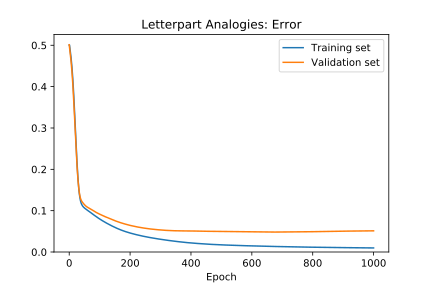

       |  Training |  Validate |      body |      brim |       val |       val 
Epochs |     Error |     Error |       acc |       acc |  body acc |  brim acc 
------ | --------- | --------- | --------- | --------- | --------- | --------- 
# 1000 |   0.00981 |   0.05122 |   0.79909 |   0.74429 |   0.40000 |   0.40000 


In [33]:
net.train(1000, accuracy=1.0, tolerance=0.4, plot=True, 
          batch_size=len(net.dataset.train_inputs), 
          report_rate=100)

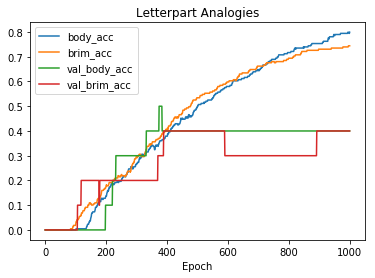

In [34]:
net.plot(".*acc")

<IPython.core.display.Javascript object>

<Network name='Letterpart Analogies' (compiled)>
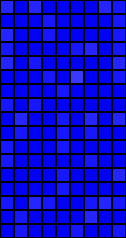
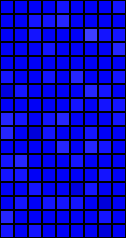
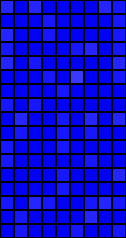
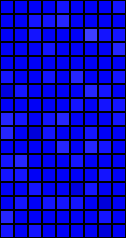
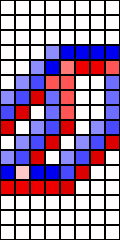
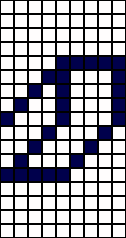

In [11]:
net

In [12]:
results = net.train_one(ds.inputs[8], ds.targets[1], visualize=True)

## Gridfonts - leter recognition


In [8]:
ds = Dataset.get("gridfonts")

In [9]:
ds.summary()

**Dataset name: Gridfonts**

This dataset originates from Douglas Hofstadter's research 
group:

http://goosie.cogsci.indiana.edu/pub/gridfonts.data

![Gridfont Grid](https://github.com/Calysto/conx/raw/master/data/grid.png)

These data have been processed to make them neural
network friendly:

https://github.com/Calysto/conx/blob/master/data/gridfonts.py

The dataset is composed of letters on a 25 row x 9 column
grid. The inputs and targets are identical, and the labels
contain a string identifying the letter.

You can read a thesis using part of this dataset here:
https://repository.brynmawr.edu/compsci_pubs/78/

**Dataset Split**:
   * training  : 7462
   * testing   : 0
   * total     : 7462

**Input Summary**:
   * shape  : [(25, 9)]
   * range  : [(0.0, 1.0)]

**Target Summary**:
   * shape  : [(25, 9)]
   * range  : [(0.0, 1.0)]



In [10]:
net = Network("Gridfonts")
net.add(Layer("inputs", (25,9)))
net.add(FlattenLayer("flatten"))
net.add(Layer("hiddens", 20, activation="sigmoid"))
net.add(Layer("outputs", (25, 9), activation="relu"))
net.connect()
net.compile(error="mse", optimizer="adam")

In [11]:
net.set_dataset(ds)

In [12]:
display(net)
output = net.propagate(ds.inputs[26], visualize=True)
print(ds.labels[26])

<IPython.core.display.Javascript object>

<Network name='Gridfonts' (compiled)>

a


In [13]:
def display_letter(letter):
    print("Letter")
    for row in range(25):
        for col in range(9):
            print("." if letter[row][col] == 0 else "X", end="")
        print()

In [14]:
display_letter(ds.inputs[0])

Letter
.........
.........
.........
.........
.........
.........
.........
.........
....XXXXX
...XX...X
..X.X...X
.X..X...X
X...X...X
...X...X.
..X...X..
.X...X...
XXXXX....
.........
.........
.........
.........
.........
.........
.........
.........
